In [261]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import csv
import math
import time
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Global variables

In [408]:
data_folder = 'data/'
training_data = data_folder + 'train.csv'
testing_data = data_folder + 'test.csv'

methods = ['mse', 'mae', 'cross-enthropy']
method = methods[2]

pos_weight = 0.5

# Load the data

We map the 'b' and 's' labels to 0 and 1 respectively.

In [221]:
def load_data():
    Y = np.genfromtxt(training_data, delimiter=',', dtype=None, skip_header=1, usecols=[1], converters={1: lambda x: 0 if b'b'==x else 1})
    
    data = np.genfromtxt(training_data, delimiter=',', skip_header=1)
    X = data[:, 2:]
    
    return X, Y

In [222]:
X, Y = load_data()

## Clean and standardize the features

### Counting the number of invalid datapoints per column

In [226]:
invalids = np.count_nonzero(X == -999, axis=0)
print(invalids)

[ 38114      0      0      0 177457 177457 177457      0      0      0
      0      0 177457      0      0      0      0      0      0      0
      0      0      0  99913  99913  99913 177457 177457 177457      0]


Therefore we get rid of columns [0,4,5,6,12,23,24,25,26,27,28]

In [227]:
def clean_and_standardize_features(X):
    X_clean = np.delete(X,[0,4,5,6,12,23,24,25,26,27,28], axis=1)
    X_standardized = (X_clean - X_clean.mean(axis=0))/X_clean.std(axis = 0)
    X_standardized = np.insert(X_standardized, 0, 1, axis=1)
    return X_standardized

In [228]:
X_standardized = clean_and_standardize_features(X)

## Methods from lab1 and lab2

We decided to use the sigmoid function: $$S(z) = \frac{1}{1 + e^{-z}}$$ <br />
to map the predicted values to probabilities of the event being a signal(1) rather than background(0) 

In [289]:
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

In [231]:
def predict(x, w):
    temp = x@w
    sigmoid_vec = np.vectorize(sigmoid)
    return sigmoid_vec(temp)

We use the cross-enthropy cost function for loss computation: 
$$J(\theta) = -\frac{1}{N} * (y^T log(Xw) + (1-y)^T log(1-Xw))$$

In [296]:
def compute_loss(y, tx, w):
    predictions = tx@w
    error = y-predictions
    #print(error.shape)
    #print((error*error).shape)
    if(method == 'mse'):
        return 1/(2*y.shape[0])*np.sum(error*error)
    elif(method == 'mae'):
        return 1/(2*y.shape[0])*np.sum(np.abs(error))
    elif(method == 'cross-enthropy'):
        predictions = predict(tx, w)
        return np.sum(-y*np.log(predictions)*pos_weight + (1-y)*np.log(1-predictions))/y.shape[0]

In [237]:
def grid_search(y, tx, w0, w1):
    losses = np.zeros((len(w0), len(w1)))
    for i in range(len(w0)):
        for j in range(len(w1)):
            losses[i][j] = compute_loss(y, tx, np.array([w0[i], w1[j]]))
    return losses

In [238]:
def compute_gradient(y, tx, w):
    if(method=='cross-enthropy'):
        prediction = predict(tx, w)
    else:
        prediction = tx@w
    error = y-prediction
    gradient = -1/y.shape[0]*tx.T@error
    return gradient

In [259]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    i = 0
    w_res = initial_w
    loss_hist = []
    w = initial_w
    for n_iter in range(max_iters):
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        w = w - gamma * gradient
        # store w and loss
        w_res = w
        loss_hist.append(loss)
        #print("Gradient Descent({bi}/{ti}): loss={l}".format(
              #bi=n_iter, ti=max_iters - 1, l=loss))
        # Log Progress
        i = i + 1
        if i % 1000 == 0:
            print("iter: " + str(i) + " loss: "+str(loss_hist[-1]))

    return loss_hist, w_res

In [240]:
def batch_iter(y, tx, batch_size, num_batches=1, shuffle=True):
    """
    Generate a minibatch iterator for a dataset.
    Takes as input two iterables (here the output desired values 'y' and the input data 'tx')
    Outputs an iterator which gives mini-batches of `batch_size` matching elements from `y` and `tx`.
    Data can be randomly shuffled to avoid ordering in the original data messing with the randomness of the minibatches.
    Example of use :
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32):
        <DO-SOMETHING>
    """
    data_size = len(y)

    if shuffle:
        shuffle_indices = np.random.permutation(np.arange(data_size))
        shuffled_y = y[shuffle_indices]
        shuffled_tx = tx[shuffle_indices]
    else:
        shuffled_y = y
        shuffled_tx = tx
    for batch_num in range(num_batches):
        start_index = batch_num * batch_size
        end_index = min((batch_num + 1) * batch_size, data_size)
        if start_index != end_index:
            yield shuffled_y[start_index:end_index], shuffled_tx[start_index:end_index]


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    w_res = initial_w
    loss_res = 0
    w = initial_w
    ti = max_iters
    for minibatch_y, minibatch_tx in batch_iter(y, tx, 32, max_iters):
        gradient = compute_gradient(minibatch_y, minibatch_tx, w)
        loss = compute_loss(minibatch_y, minibatch_tx, w)
        w = w- gamma * gradient
        # store w and loss
        w_res = w
        loss_res = loss
    return loss_res, w_res

### Additional methods

We label the results <0.5 to -1, and the rest to 1

In [433]:
#set the threshold to 0.618 for mse, 0.458 for cross-enthropy
def label_results(Y_predicted):
    f = lambda x: -1 if x<0.458 else 1
    f_vec = np.vectorize(f)
    return f_vec(Y_predicted)

In [242]:
def performance(Y, Y_predicted):
    return np.sum(Y == Y_predicted)/Y.shape[0]

In [279]:
def evaluate_performance(Y, Y_predicted):
    false_negatives = 0
    true_negatives = 0
    false_positives = 0
    true_positives = 0
    for i in range(Y.shape[0]):
        if(Y[i]==-1):
            if(Y_predicted[i]==-1):
                true_negatives += 1
            else:
                false_positives += 1
        else:
            if(Y_predicted[i]==-1):
                false_negatives += 1
            else:
                true_positives += 1
    print('True positives: ' + str(true_positives))
    print('False positives: ' + str(false_positives))
    print('True negatives: ' + str(true_negatives))
    print('False negatives: ' + str(false_negatives))

## Trying gradient descent

/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/Users/michal/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in multiply
  if sys.path[0] == '':


iter: 1000 loss: -0.09679397574456566
[-8.73494804e-01 -6.82876112e-01 -8.98190458e-01  2.89303039e-01
  9.73901777e-01 -1.27568761e-01 -5.66101388e-02 -5.43299412e-01
  2.91476923e-01  6.02354370e-01 -3.19141320e-03 -2.50605404e-03
  7.90827804e-01 -1.29274929e-03  6.50359620e-03  1.36025922e-01
  4.31709331e-04 -1.97273737e-01  2.17392854e-01 -1.09299883e-01]


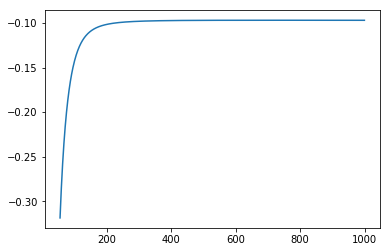

In [438]:
max_iters = 1000
gamma = 0.15
batch_size = 1

losses, w = gradient_descent(Y, X_standardized, np.ones(X_standardized.shape[1]), max_iters, gamma)
print(w)
plt.plot(losses)

In [439]:
Y_predicted = predict(X_standardized, w)
Y_labeled = label_results(Y_predicted)
print(performance(Y_labeled, label_results(Y)))
# 0.735 for mse
#0.74038 for cross-enthropy

0.740504


In [436]:
evaluate_performance(label_results(Y), Y_labeled)

True positives: 50600
False positives: 29838
True negatives: 134495
False negatives: 35067


# Oversampling the signal class

## Load test data

In [347]:
test_data = np.genfromtxt(testing_data, delimiter=',', skip_header=1)
test_X = test_data[:, 2:]
test_X_standardized = clean_and_standardize_features(test_X)

In [405]:
test_predictions = label_results(predict(test_X_standardized, w))
test_ids = range(350000,918238)

In [406]:
test_results = np.column_stack([test_ids, test_predictions])
suffix = time.time()
np.savetxt('submission' + str(suffix) + '.csv', test_results, fmt="%d", delimiter=",", header="Id,Prediction", comments='')